In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install theano
!{sys.executable} -m pip install pymc3

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import theano
import pymc3 as pm

C:\Users\james\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
text_count = np.loadtxt("data/txtdata.csv")

In [4]:
text_count

array([13., 24.,  8., 24.,  7., 35., 14., 11., 15., 11., 22., 22., 11.,
       57., 11., 19., 29.,  6., 19., 12., 22., 12., 18., 72., 32.,  9.,
        7., 13., 19., 23., 27., 20.,  6., 17., 13., 10., 14.,  6., 16.,
       15.,  7.,  2., 15., 15., 19., 70., 49.,  7., 53., 22., 21., 31.,
       19., 11., 18., 20., 12., 35., 17., 23., 17.,  4.,  2., 31., 30.,
       13., 27.,  0., 39., 37.,  5., 14., 13., 22.])

In [5]:
num_text= len(text_count) 

Text(0.5,1,'Message habbit')

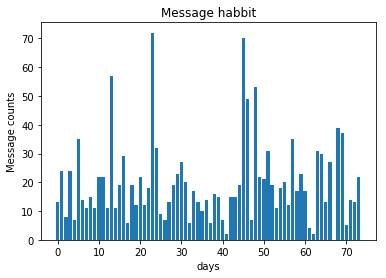

In [6]:
plt.bar(np.arange(num_text), text_count)
plt.xlabel("days")
plt.ylabel("Message counts")
plt.title("Message habbit")

In [7]:
alpha = 1./text_count.mean()
alpha

0.05065023956194388

In [8]:
# Lambda for possion dist.
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=num_text)

In [9]:
with model:
    idx = np.arange(num_text) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [10]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=text_count)

In [11]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 60000/60000 [00:42<00:00, 1419.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [13]:
tau_samples

array([45, 45, 45, ..., 44, 44, 44], dtype=int64)

In [16]:
lambda_1_samples

array([16.45060564, 16.98333444, 16.98333444, ..., 18.35199373,
       18.35199373, 18.35199373])

C:\Users\james\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


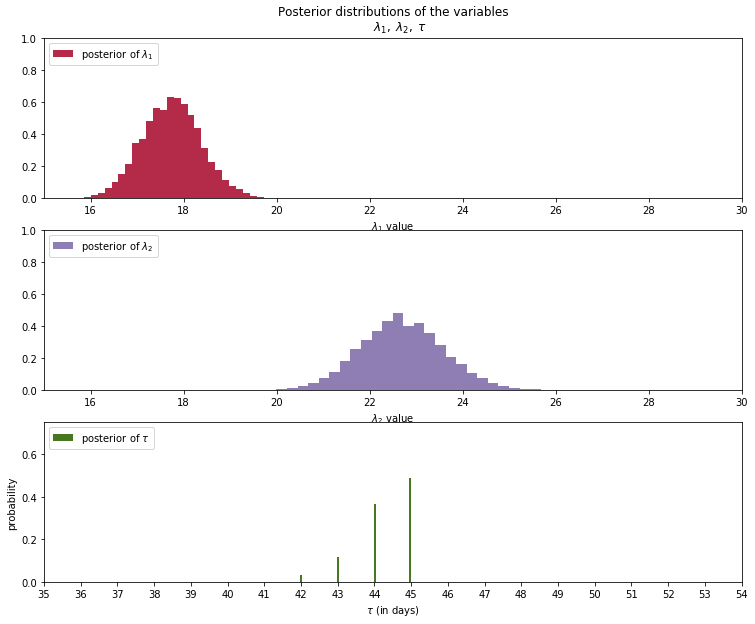

In [14]:
from IPython.core.pylabtools import figsize
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=num_text, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(num_text))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(text_count)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

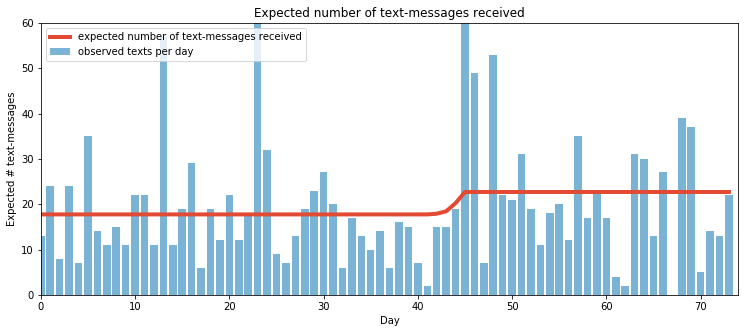

In [15]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(num_text)
for day in range(0, num_text):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(num_text), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, num_text)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(num_text), text_count, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");